# Training left vs. right classifier

1. Load data and add labels
3. Preprocess text
4. Extract features
5. Divide into training and testing sets
6. Train model on training set
7. Test model on testing set
8. Save best model

## 1. Load data and add labels

In [78]:
import glob
import os
import codecs
import json 

from joblib import Parallel, delayed
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
folderpath = '/home/hubert/Documents/kesseca/data/outlets_27_plus'
filepaths = glob.glob(os.path.join(folderpath, '*.json'))

In [48]:
# Political spectrum labels
political_labels = {"abc-news": 3,
                    "al-jazeera-english": 3,
                    "associated-press": 3,
                    "axios": 3,
                    "bbc-news": 3,
                    "bloomberg": 3,
                    "breitbart-news": 5,
                    "breitbard-news": 5,
                    "business-insider": 3,
                    "cnbc": 3,
                    "cnn": 3,
                    "fox-news": 4,
                    "msnbc": 1,
                    "nbc-news": 3,
                    "newsweek": 2,
                    "new-york-magazine": 1,
                    "politico": 2,
                    "reuters": 3,
                    "the-economist": 2,
                    "the-guardian-uk": 2,
                    "the-hill": 3,
                    "the-new-york-times": 2,
                    "the-huffington-post": 2,
                    "the-telegraph": 4,
                    "the-wall-street-journal": 3,
                    "the-washington-post": 2,
                    "the-washinton-post": 2,
                    "time": 1,
                    "usa-today": 3,
                    "vice-news": 1,
                    "cbs-news": 3,
                    "google-news": 3}

In [49]:
# Load the JSON files
data = []

for path in filepaths:
    with codecs.open(path, 'r', encoding='utf8') as f:
        data.append(json.load(f))

In [50]:
file_origin = [f.split('/')[-1][:-5] for f in filepaths]

In [51]:
# Put in a simpler format
labels_political = []
labels_location = []
articles = []

for origin, outlet in zip(file_origin, data):
    for article in outlet['articles']['results']:
        try:
            labels_political.append(political_labels[origin])
            labels_location.append(article['source']['location']['label']['eng'])
            articles.append(article['body'])
        except:
            print('Failed: ' + origin)

/home/hubert/.pyenv/versions/3.5.1/envs/kesseca/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


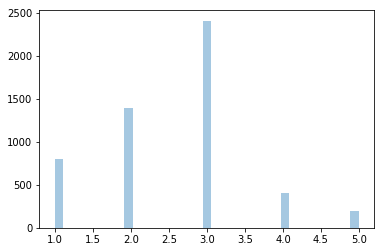

In [54]:
sns.distplot(labels_political, kde=False)

In [57]:
set(labels_location)

{'Arlington, Texas',
 'Atlanta, Georgia',
 'London',
 'Los Angeles',
 'McLean, Virginia',
 'New Jersey',
 'New York',
 'New York City',
 'United States',
 'Washington (state)'}

## 2. Preprocess text

In [95]:
from sklearn.feature_extraction import text


count_vect = text.CountVectorizer(stop_words='english')
counts = count_vect.fit_transform(articles)

tfidf_transformer = text.TfidfTransformer(sublinear_tf=True)
tfidf_data = tfidf_transformer.fit_transform(counts).todense()

In [110]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

lr = LogisticRegression(class_weight='balanced')

In [111]:
# Just keep extreme examples
y = np.array(labels_political)

X = tfidf_data[(y < 2) | (y > 4)]
y = y[(y < 2) | (y > 4)]

y[y < 3] = 0
y[y > 3] = 1

In [112]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=0, shuffle=True)

lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)

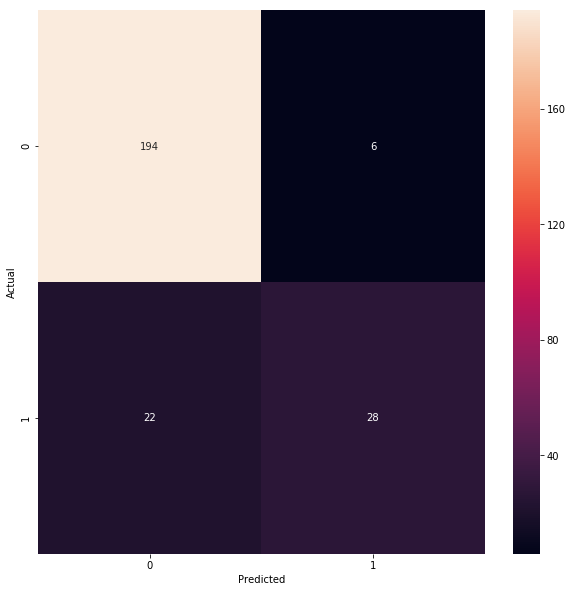

In [113]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(conf_mat, annot=True, fmt='d')
#             xticklabels=category_id_df.Product.values, yticklabels=category_id_df.Product.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [116]:
accuracies = cross_val_score(lr, X, y, scoring='accuracy', cv=5)
np.mean(accuracies)

0.8640000000000001